## INTRODUCTION

In this project, we conduct a comprehensive analysis of popularity scores within a dataset of music tracks from the Spotify API. Our goal is to provide actionable recommendations to management or record labels, driving strategic decision-making and optimizing investments in tracks based on predictive insights.

The music industry is dynamic and competitive, with countless tracks vying for listeners' attention. Understanding what makes a song popular is crucial for success in this landscape. By leveraging advanced data analytics techniques, we aim to uncover the underlying factors that contribute to a track's popularity and develop robust predictive models.

Our analysis encompasses various aspects of music, including audio features, artist metadata, and historical performance data. By exploring correlations and patterns within the dataset, we seek to identify key predictors of popularity and quantify their impact on audience engagement.

The insights generated from our predictive models will enable stakeholders to make informed decisions when selecting and promoting tracks. Whether it's identifying promising new artists, optimizing marketing strategies, or curating playlists, our predictions will serve as a valuable resource for driving growth and maximizing the impact of music releases.

## LIBRARIES AND SETUP

In [1]:
# Import libraries used in the project.
import requests
import base64
import json
from dotenv import load_dotenv
import os

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
import pandas as pd
import numpy as np
import time

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, average_precision_score

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
import matplotlib.cm as cm

In [8]:
from scipy.stats import ttest_ind

In [9]:
from sklearn.preprocessing import LabelEncoder
import random

In [10]:
# Securely transfer client_id and client_secret from a separte file within the working directory.
load_dotenv()
client_id = os.getenv('client_id')
client_secret = os.getenv('client_secret')

In [11]:
# Function that encodes client_id and client_secret in order to obtain access token. A method of authentication required by Spotify's API.
def get_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_header = {
        'Authorization': f'Basic {base64.b64encode((client_id + ":" + client_secret).encode()).decode()}'
    }
    auth_data = {
        'grant_type': 'client_credentials',
        'client_id' : client_id,
        'client_secret': client_secret
    }
    auth_response = requests.post(auth_url, data = auth_data, headers = auth_header)
    auth_response_data = auth_response.json()
    access_token = auth_response_data['access_token']
    return access_token

In [12]:
token = get_token(client_id, client_secret)

In [13]:
# Function that uses the acccess token to obtain a list of genres with a limit of 50.
def get_genres(access_token, limit = 50, offset = 0):
    
    genres_url = 'https://api.spotify.com/v1/browse/categories'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'limit': limit,
        'offset': offset
    }
    
    response = requests.get(genres_url, headers = headers, params = params)
    genres_data = response.json()
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]
    return genres

In [14]:
sp_genres = get_genres(token)

In [15]:
print("List of genres:")
print("------------------------------")
for genre_id, genre_name in sp_genres:
    print(f"{genre_name}")

List of genres:
------------------------------
Made For You
New Releases
Spotify CLASSICS
Hip-Hop
Pop
Country
Charts
Asian Pacific Islander Heritage Month
Latin
Student
Rock
Discover
Dance/Electronic
In the car
Mood
Indie
Disney
R&B
Christian & Gospel
Workout
Música Mexicana
La Tierra del Corrido
K-pop
Chill
Netflix
Sleep
Party
At Home
Decades
Love
Metal
Jazz
Trending
Frequency
Classical
Folk & Acoustic
Focus
Soul
Kids & Family
Gaming
Anime
TV & Movies
Instrumental
Punk
Ambient
Blues
Cooking & Dining
Alternative
Travel
Caribbean


## DATA EXTRACTION, PREPROCESSING AND EXPLORATION

In [16]:
# Spotipy library is used and initialized below with Spotify API credentials.
client_credentials_manager = SpotifyClientCredentials(client_id = client_id, client_secret = client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [17]:
# Function that creates a dataframe with an initial empty dictionary with key column names. 
def create_dataframe(query_list, limit=50, offset = 0):
    data = {
        'Track ID': [],
        'Track Name': [],
        'Artist Name': [],
        'Popularity Score': [],
        'Release Year': [],
        'Genre': [],
        'Explicit': []
    }
    
    # Fetch the first 'limit' tracks for each genre.
    for query in query_list:
        search_results = sp.search(query, limit = limit, type = 'track')
        tracks = search_results['tracks']['items']
    
        # Extract desired information for each track and store it in the data dictionary.
        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track Name'].append(track['name'])
            data['Artist Name'].append(track['artists'][0]['name'])
            data['Popularity Score'].append(track['popularity'])
            data['Release Year'].append(track['album']['release_date'][:4])
            data['Genre'].append(query)
            data['Explicit'].append(track['explicit'])
        
        # Wait period of 2 seconds included after each genre's search to avoid reaching rate limit.
        time.sleep(2)
    
    # A dataframe is created from the dictionary.
    df = pd.DataFrame(data)
    return df

From the list of available "genres" in the Spotify API, we will pick the more traditional genres, such as "Pop", "Rock", "Hip-Hop", etc., for our analysis. 

In [18]:
# List of genres

genres = ['Hip-Hop', 'Pop', 'Country', 'Latin', 'Rock', 'R&B', 'Dance/Electronic', 'Indie', 'Sleep', 
          'Christian & Gospel', 'Regional Mexican', 'Kids & Family', 'Jazz', 'Romance', 'Folk & Acoustic', 'K-Pop', 
          'Instrumental', 'Alternative', 'Classical', 'Soul', 'Punk', 'Pop culture', 'Blues', 'Desi', 'Arab', 'Afro', 'Metal', 
          'Musica Mexicana', 'Love', 'Caribbean', 'Grunge', 'Alternative Rock', 'Reggae']

In [19]:
random.seed(100)
# Use the 'create_dataframe' function to create a dataframe with 50 tracks from each genre
df = create_dataframe(genres, limit = 50)

We will take a quick look at the track data available through the Spotify API:

In [20]:
df

Track ID                        Track Name  \
0     2HoDr1yVksl19omOhc1zWy                           Hip-Hop   
1     1SyQ6t9RdRBK0QUCS6a797                    Hip Hop Hooray   
2     4c9XojqJDu7KNCh8GmNbj5                     Hip Hop Phile   
3     23FMZRrUJKHdtXuxDAuhRA                           Hip-Hop   
4     0Qw7i43X5zPUpod1Dlb2JP                   Hip Hop Misfits   
...                      ...                               ...   
1645  3Nrsd3StuJOC9Ha1BH63Mm                      Reggae Vibes   
1646  2F6lnnabTU50eiqHVglNxn                            Reggae   
1647  4yAuDg4xikV3lEHqcddAGq            Reggae Round the World   
1648  1jtEghCuYsgtmWdpvupef7  I Heard It Through the Grapevine   
1649  1h3kzkZNBu0HJ8gl7mRpst                            Reggae   

              Artist Name  Popularity Score Release Year    Genre  Explicit  
0               Dead Prez                60         2000  Hip-Hop      True  
1       Naughty By Nature                68         1993  Hip-Hop     False  
2                     BTS                56         2014  Hip-Hop     False  
3            Freddy Rugga                20         2016  Hip-Hop      True  
4             Dirty Heads                31         2012  Hip-Hop      True  
...                   ...               ...          ...      ...       ...  
1645     Dreadlock Island                14         2023   Reggae     False  
1646                Etana                20         2012   Reggae     False  
1647           Brian Hall                37         2023   Reggae     False  
1648  Toots & The Maytals                19         2004   Reggae     False  
1649       Cheetah Mobile                12         2018   Reggae     False  

[1650 rows x 7 columns]

We will confirm that we have pulled 50 tracks worth of data for each "genre".

In [21]:
df['Genre'].value_counts()

Genre
Hip-Hop               50
Alternative           50
Alternative Rock      50
Grunge                50
Caribbean             50
Love                  50
Musica Mexicana       50
Metal                 50
Afro                  50
Arab                  50
Desi                  50
Blues                 50
Pop culture           50
Punk                  50
Soul                  50
Classical             50
Instrumental          50
Pop                   50
K-Pop                 50
Folk & Acoustic       50
Romance               50
Jazz                  50
Kids & Family         50
Regional Mexican      50
Christian & Gospel    50
Sleep                 50
Indie                 50
Dance/Electronic      50
R&B                   50
Rock                  50
Latin                 50
Country               50
Reggae                50
Name: count, dtype: int64

The statistics below tell us that we have low popularity scores in our data, with an average of 37.4 and 75% of the data having a score below 55. Additionally, there are tracks with a minimum score of 0, and a maximum score of 94.

In [22]:
df.describe()

Popularity Score
count       1650.000000
mean          37.431515
std           22.549598
min            0.000000
25%           20.000000
50%           36.000000
75%           55.000000
max           94.000000

The distribution of popularity scores seems to be multimodal with a slight skewness to the right, and this should be taken into consideration at the modeling stage.

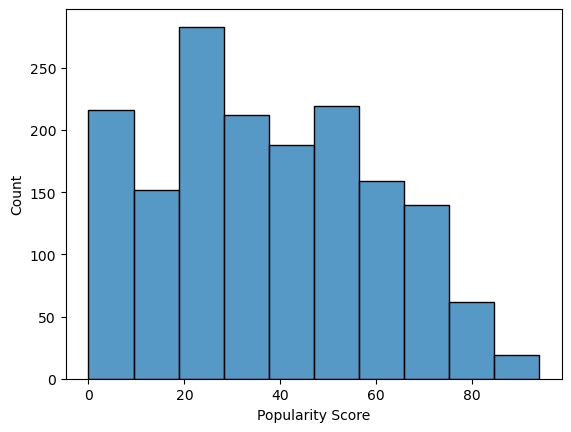

In [23]:
sns.histplot(df['Popularity Score'], bins=10)
plt.show()

Checking for missing values below, we don't seem to have any in our data.

In [24]:
print("Column          Missing values")
print("------------------------------")
print(df.isnull().sum())

Column          Missing values
------------------------------
Track ID            0
Track Name          0
Artist Name         0
Popularity Score    0
Release Year        0
Genre               0
Explicit            0
dtype: int64


We will create a function to pull audio features data from the Spotify API

In [25]:
# Function to fetch audio features data from Spotify API
def get_audio_features(track_ids):
    features_list = []
    
    for i in range(0, len(track_ids), 50):
        batch = track_ids[i:i + 50]
        features_results = sp.audio_features(batch)
        features_list += features_results
        
    return features_list

In [26]:
track_ids = df['Track ID'].tolist()

In [27]:
random.seed(200)
audio_features_data = get_audio_features(track_ids)

In [28]:
# Filter out None values
filtered_audio_features = [features for features in audio_features_data if features is not None]

In [29]:
audio_features_df = pd.DataFrame(filtered_audio_features)

We'll take a quick look at the audio features data below:

In [30]:
audio_features_df

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.725   0.737    4    -7.453     1       0.3240      0.000633   
1            0.862   0.642    6   -13.652     0       0.1010      0.102000   
2            0.796   0.878    1    -3.325     1       0.1850      0.171000   
3            0.807   0.558    6   -13.857     1       0.3670      0.068800   
4            0.656   0.953    8    -4.265     1       0.2880      0.223000   
...            ...     ...  ...       ...   ...          ...           ...   
1639         0.914   0.421    2   -10.957     1       0.0453      0.284000   
1640         0.655   0.534    4    -5.040     1       0.0785      0.068700   
1641         0.802   0.644   11    -8.190     0       0.3060      0.006360   
1642         0.758   0.799    7    -7.136     1       0.1850      0.323000   
1643         0.806   0.604   11    -8.235     0       0.0451      0.005110   

      instrumentalness  liveness  valence    tempo            type  \
0             0.004170    0.1090    0.219   77.162  audio_features   
1             0.000000    0.2720    0.765   99.200  audio_features   
2             0.000000    0.2340    0.795  144.000  audio_features   
3             0.000000    0.1050    0.559  164.004  audio_features   
4             0.000000    0.5750    0.690   93.981  audio_features   
...                ...       ...      ...      ...             ...   
1639          0.000008    0.1570    0.915   89.983  audio_features   
1640          0.000004    0.0734    0.589   73.980  audio_features   
1641          0.000000    0.2900    0.905  165.061  audio_features   
1642          0.000000    0.2780    0.848  112.414  audio_features   
1643          0.691000    0.0720    0.771  103.027  audio_features   

                          id                                   uri  \
0     2HoDr1yVksl19omOhc1zWy  spotify:track:2HoDr1yVksl19omOhc1zWy   
1     1SyQ6t9RdRBK0QUCS6a797  spotify:track:1SyQ6t9RdRBK0QUCS6a797   
2     4c9XojqJDu7KNCh8GmNbj5  spotify:track:4c9XojqJDu7KNCh8GmNbj5   
3     23FMZRrUJKHdtXuxDAuhRA  spotify:track:23FMZRrUJKHdtXuxDAuhRA   
4     0Qw7i43X5zPUpod1Dlb2JP  spotify:track:0Qw7i43X5zPUpod1Dlb2JP   
...                      ...                                   ...   
1639  3Nrsd3StuJOC9Ha1BH63Mm  spotify:track:3Nrsd3StuJOC9Ha1BH63Mm   
1640  2F6lnnabTU50eiqHVglNxn  spotify:track:2F6lnnabTU50eiqHVglNxn   
1641  4yAuDg4xikV3lEHqcddAGq  spotify:track:4yAuDg4xikV3lEHqcddAGq   
1642  1jtEghCuYsgtmWdpvupef7  spotify:track:1jtEghCuYsgtmWdpvupef7   
1643  1h3kzkZNBu0HJ8gl7mRpst  spotify:track:1h3kzkZNBu0HJ8gl7mRpst   

                                             track_href  \
0     https://api.spotify.com/v1/tracks/2HoDr1yVksl1...   
1     https://api.spotify.com/v1/tracks/1SyQ6t9RdRBK...   
2     https://api.spotify.com/v1/tracks/4c9XojqJDu7K...   
3     https://api.spotify.com/v1/tracks/23FMZRrUJKHd...   
4     https://api.spotify.com/v1/tracks/0Qw7i43X5zPU...   
...                                                 ...   
1639  https://api.spotify.com/v1/tracks/3Nrsd3StuJOC...   
1640  https://api.spotify.com/v1/tracks/2F6lnnabTU50...   
1641  https://api.spotify.com/v1/tracks/4yAuDg4xikV3...   
1642  https://api.spotify.com/v1/tracks/1jtEghCuYsgt...   
1643  https://api.spotify.com/v1/tracks/1h3kzkZNBu0H...   

                                           analysis_url  duration_ms  \
0     https://api.spotify.com/v1/audio-analysis/2HoD...       214067   
1     https://api.spotify.com/v1/audio-analysis/1SyQ...       267267   
2     https://api.spotify.com/v1/audio-analysis/4c9X...       257301   
3     https://api.spotify.com/v1/audio-analysis/23FM...       213291   
4     https://api.spotify.com/v1/audio-analysis/0Qw7...       160147   
...                                                 ...          ...   
1639  https://api.spotify.com/v1/audio-analysis/3Nrs...       225581   
1640  https://api.spotify.com/v1/audio-analysis/2F6l...       349760   
1641  https://api.spotify.com/

We will now merge both datarames containing the tracks data and audio features data into one, while checking for missing and duplicate values, and making the necessary cleanup.

In [31]:
# Merge with the original DataFrame containing popularity information
merged_df = df.merge(audio_features_df, left_on = 'Track ID', right_on='id', how='inner')

In [32]:
print("Column          Missing values")
print("------------------------------")
print(merged_df.isnull().sum())

Column          Missing values
------------------------------
Track ID            0
Track Name          0
Artist Name         0
Popularity Score    0
Release Year        0
Genre               0
Explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64


In [33]:
merged_df.shape

(1694, 25)

In [34]:
# Checking for duplicate Track ID
trackid_duplicate = any(merged_df.duplicated(subset=['Track ID']))
print("Do we have duplicate Track ID or songs:", trackid_duplicate)

Do we have duplicate Track ID or songs: True


In [35]:
# Checking how many duplicates
duplicates_count =merged_df.duplicated(subset=['Track ID']).sum()

print("Number of duplicates:", duplicates_count)

Number of duplicates: 75


We seem to have 75 duplicate tracks in our data and we will need to remove them accordingly

In [36]:
# Removing duplicates from Track ID
merged_df = merged_df.drop_duplicates(subset=['Track ID'], keep='first')

In [37]:
merged_df.shape

(1619, 25)

## DATA VISUALIZATION

We will calculate the average popularity score for each genre to get an idea of the ones with the highest popularity.

In [38]:
# Calculate average popularity score by genre
pop_genre = merged_df.groupby('Genre')['Popularity Score'].mean().reset_index()

# Sorting by average popularity in descending order
pop_genre = pop_genre.sort_values('Popularity Score', ascending=False)

# Filtering the top 10
pop_genre = pop_genre.head(10)

Let's visualize the popularity of the top 10 genres

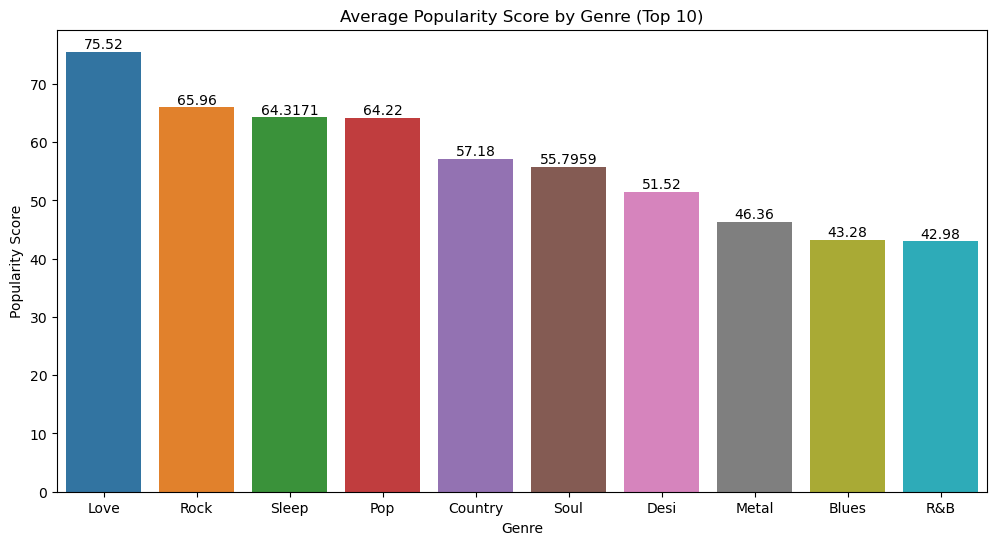

In [39]:
# Create plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Genre', y='Popularity Score', data=pop_genre)
ax.bar_label(ax.containers[0])
plt.title('Average Popularity Score by Genre (Top 10)')
plt.show()

Out of our top 10 popular genres, "Love" seems to be the most popular one with an average popularity score of 75.5%. This is followed by "Rock" and "Sleep" with an average popularity score of 66% and 64.3% respectively.

Below, we will create pair plots to identify any clear patterns between the target variable "Popularity Score" and the predictor variables.

We will first categorize the "Popularity Score" into "Low", and "High" in order to get a sense of the more prominent kind of popularity scores, while turning this into a classification problem.  

The average "Popularity Score" for our data set is 37.4%, thus we will categorize tracks below a 40% score as "Low", and those above 40% as "High".

In [40]:
# Creating popularity score categories
bins = [0, 40, 100] # Define bins
labels = ['Low', 'High'] #Define the labels for bins

# We add "Popularity Category" to original dataframe
merged_df['Popularity Category'] = pd.cut(merged_df['Popularity Score'], bins=bins, labels=labels, right=False )

In [41]:
# Specify variables to include in the pairplot
selected_vars = ['Popularity Score', 'Release Year', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'Popularity Category']

C:\Users\mpena\Anaconda3\envs\spotify\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


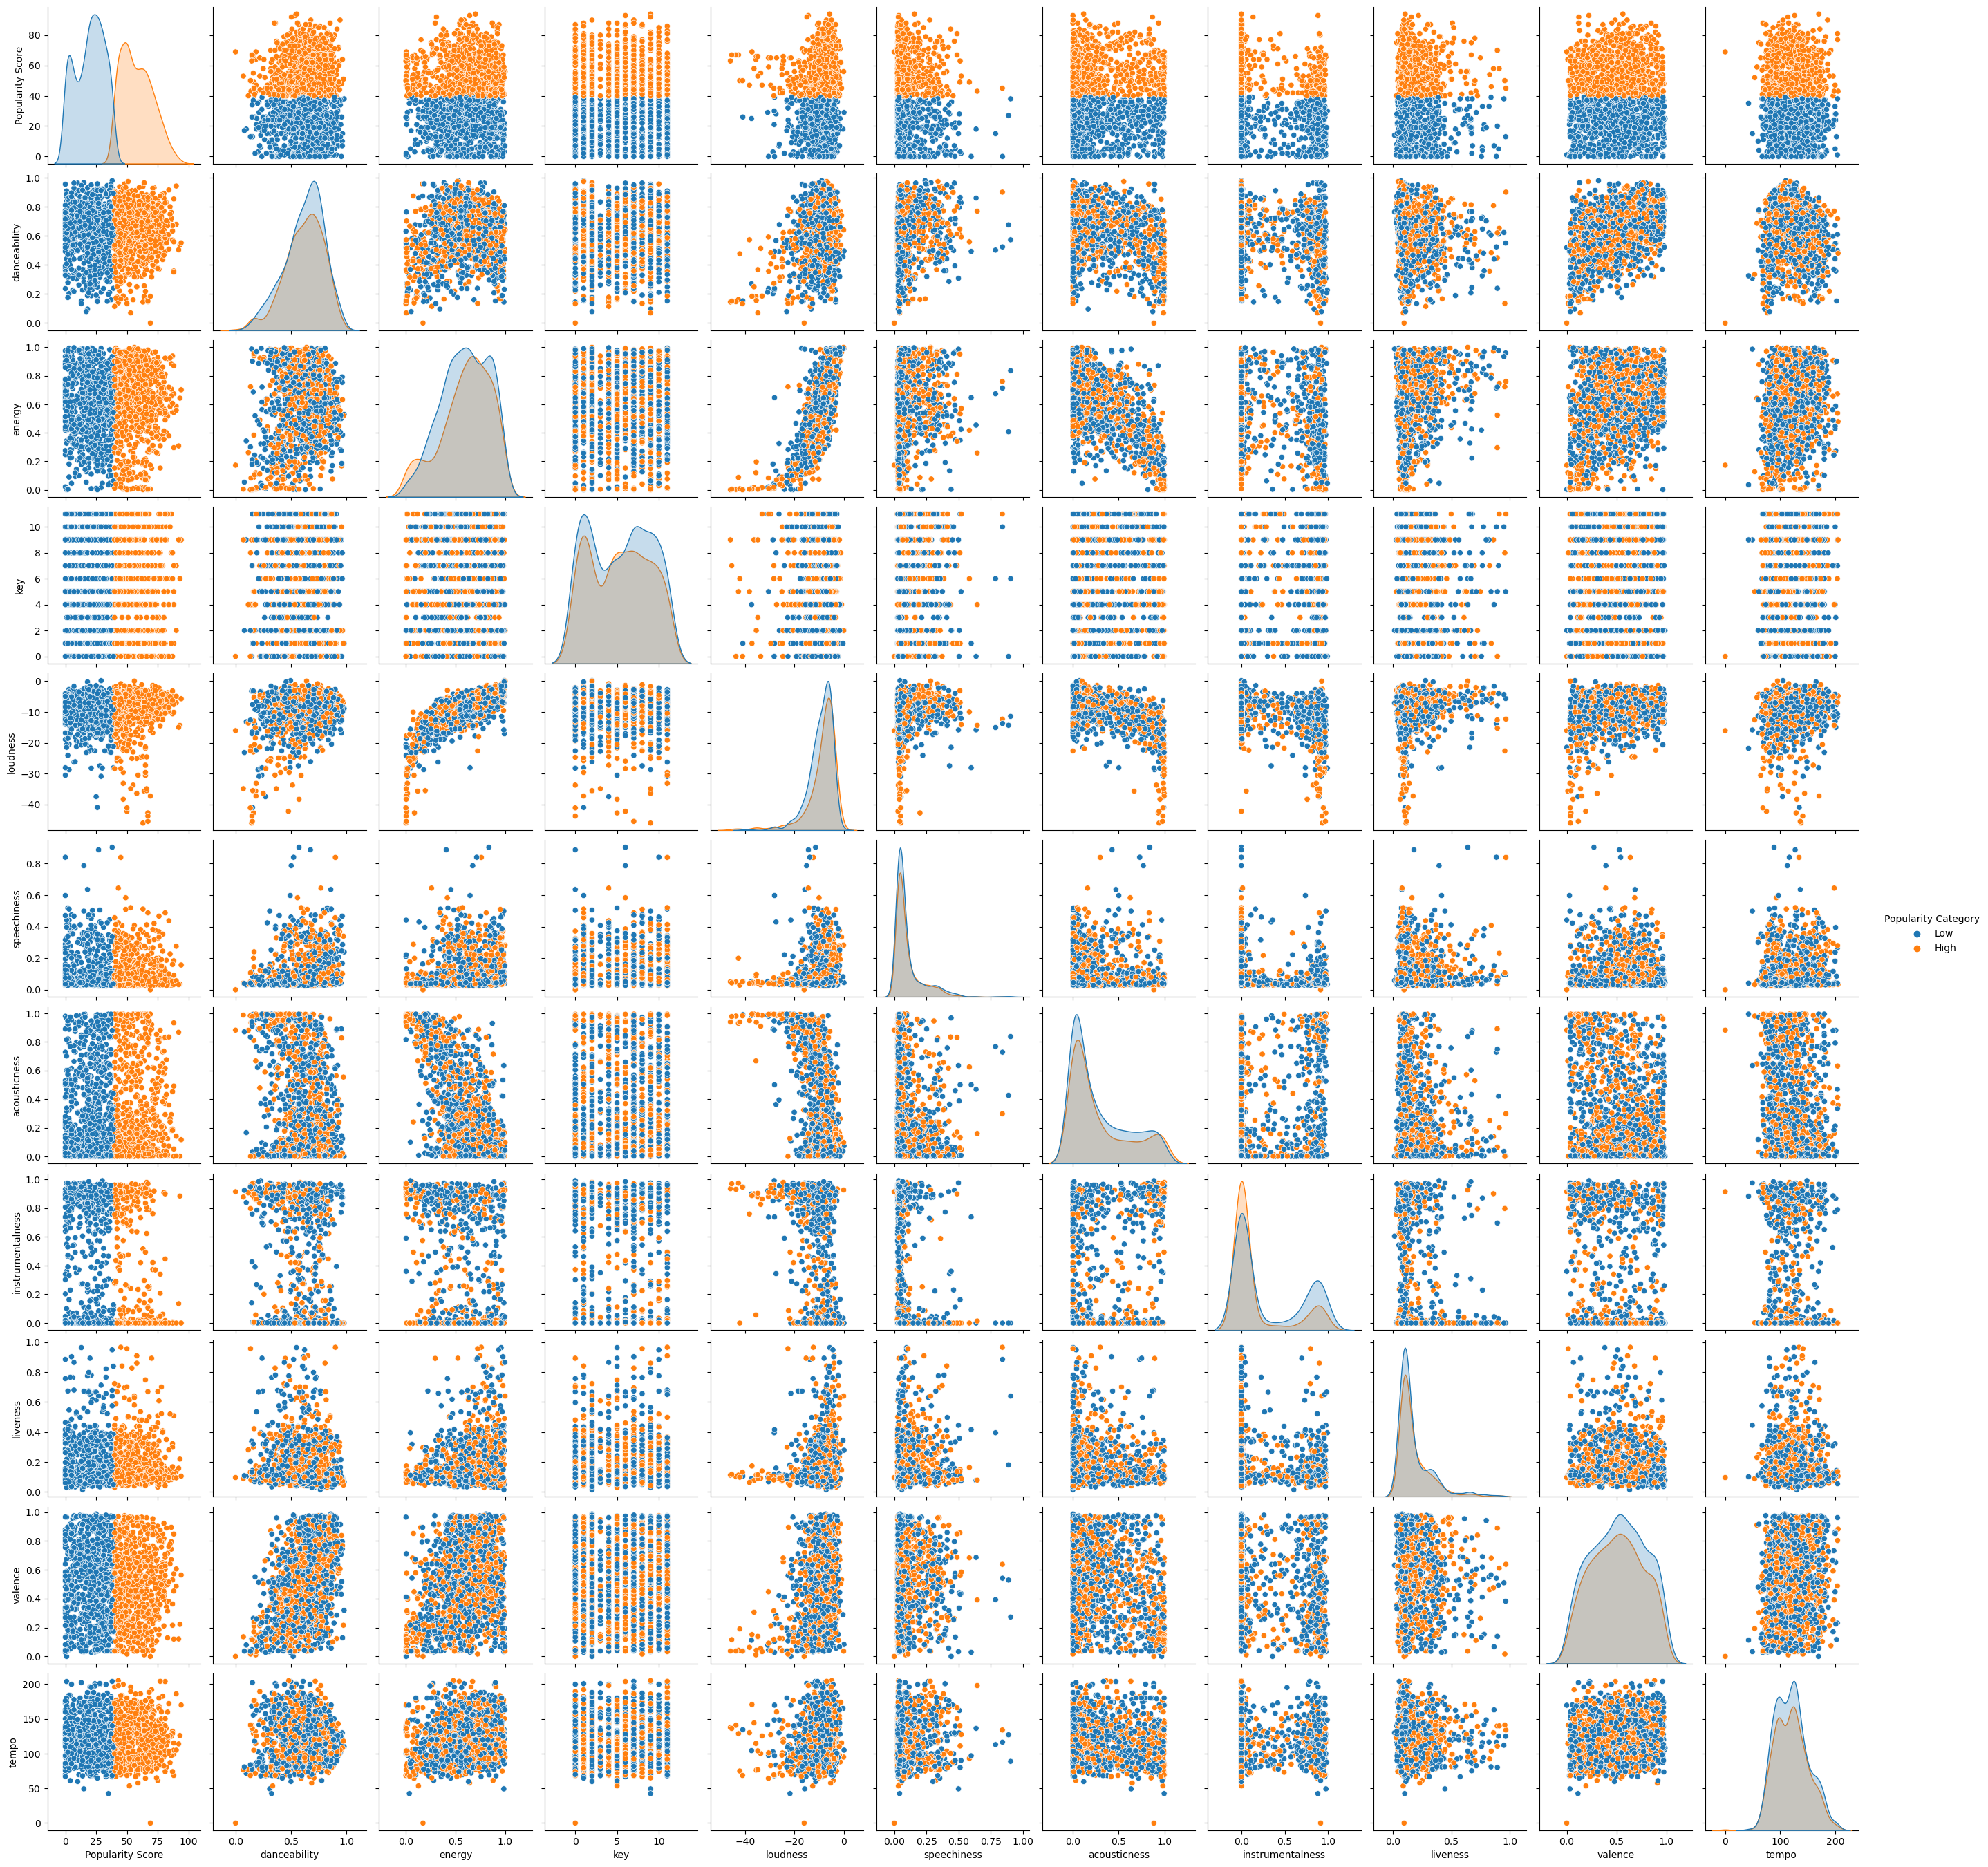

In [42]:
sns.pairplot(merged_df[selected_vars], hue='Popularity Category')
plt.show()

In [43]:
print(merged_df['loudness'].skew())
print(merged_df['speechiness'].skew())
print(merged_df['acousticness'].skew())
print(merged_df['liveness'].skew())

-2.304274612477026
2.468890047876823
0.9321728277636457
2.2706579946494365


We can observe from the visualizations above that there are 4 variable that seem to be skewed, "loudness", "speechiness", "acousticness", and "liveness". After further analysis, we have determined that there is significant skewness for three of these variables. We have applied appropriate transformations to correct the skewness, however, this had a negative impact on the performance of the models, thus we have decided to use the variables as they are.

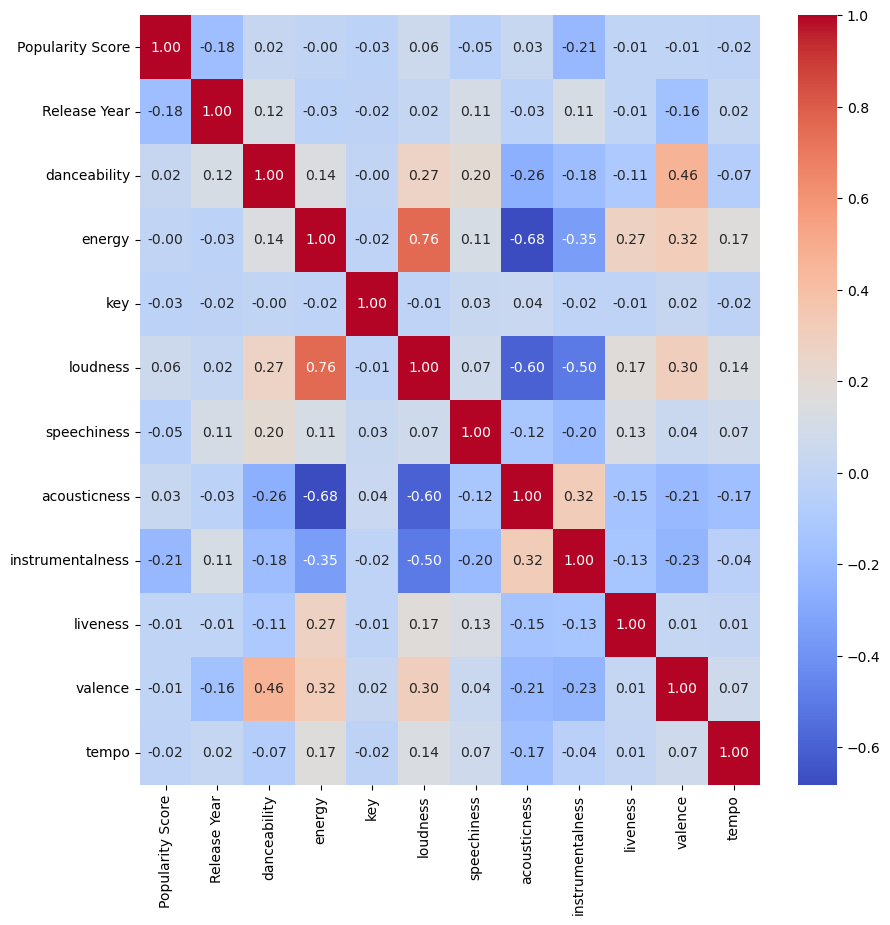

In [44]:
# Features to be included in correlation matrix
features = ['Popularity Score', 'Release Year', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Correlation Matrix
corr_matrix = merged_df[features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f', annot=True)
plt.show()

As seen above, there does not seem to be any apparent patterns between "Popularity Score" and the predictor variables in the plots. Additionally, the target variable does not have strong correlations with the predictor variables. The highest correlation seems to be with "instrumentalness" and it is a negative relationship with a coefficient of -0.21.

We can also observe that some of the predictor variables are highly correlated with one another, such as "energy" with both "loudness" and "acousticness", these last two variables also correlated with one another, and "loudness" with "instrumentalness". We will keep these variables for the models but it's important to note that we may want to eliminate one or two of them if our goal is to simplify a model for production and interpretability.

## FEATURE ENGINEERING

Given that we do not have strong correlations between our target variable and predictor variables, we will apply a feature engineering technique to combine existing features to capture interactions that might be more predictive.

In [45]:
# Interaction features
merged_df['energy_loudness'] = merged_df['energy'] * merged_df['loudness']
merged_df['speech_instrument'] = merged_df['speechiness'] * merged_df['instrumentalness']

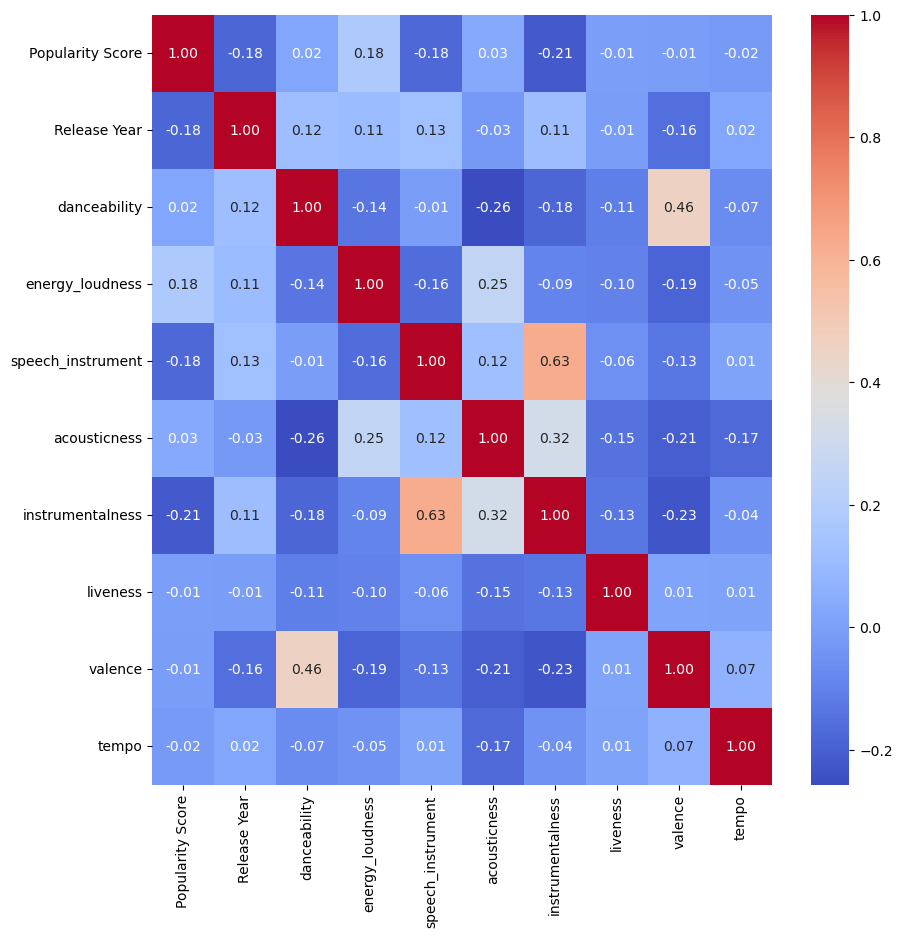

In [46]:
# Features to be included in correlation matrix
features = ['Popularity Score', 'Release Year', 'danceability', 'energy_loudness', 'speech_instrument', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Correlation Matrix
corr_matrix = merged_df[features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f', annot=True)
plt.show()

With the feature engineering technique, we were able to create two additional feature that are more predictive of "Popularity Score" than they were separately (energy_loudness and speech_instrument).

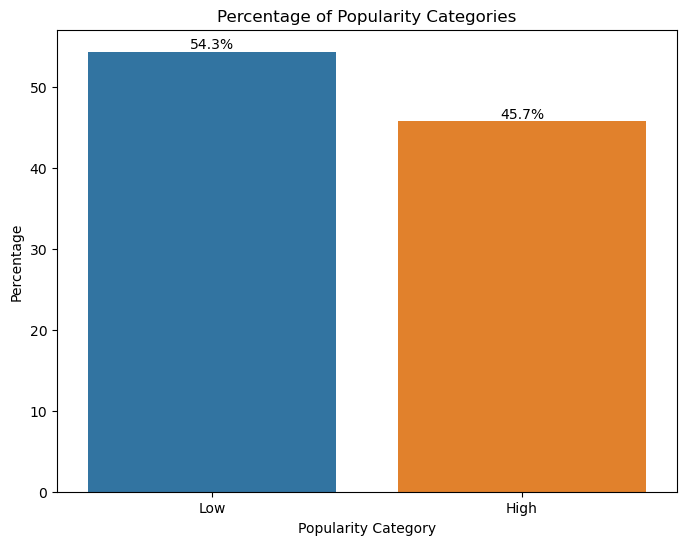

In [47]:
# Calculate percentage of each category
total_count = merged_df['Popularity Category'].count()
category_counts = merged_df['Popularity Category'].value_counts()
category_percentages = (category_counts / total_count) * 100

# Create a bar plot of category percentages
plt.figure(figsize=(8, 6))
sns.barplot(x=category_percentages.index, y=category_percentages.values)

# Add labels with percentages
for i, percentage in enumerate(category_percentages):
    plt.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

# Set labels and title
plt.xlabel('Popularity Category')
plt.ylabel('Percentage')
plt.title('Percentage of Popularity Categories')

plt.show()

We also have a slight class imbalance between the "Low" and "High" popularity score categories, but the models should be able to account for such imbalance. In the context of this project, we will aim to pick a model with high precision. This will ensure, we minimize the number of false positives or incorrectly classified "high" popularity category, thus effectively identifying tracks with the potential to have a "high" popularity score, driving strategic decision-making and optimizing investments in tracks based on predictive insights.

## PREDICTIVE STATISTICS

Since we don't have strong relationships between "Popularity Score" and the predictor variables, I have decided to turn this into a classification problem, thus we will attempt to model and predict the "Popularity Category" for this data set.

## Encode Categorical Labels

Although the models we are going to use in this project are able to handle categorical variables, some of the algorithms to calculate model performance, such as "precision" and "recall", are not adapted to such variables. We encode the categorical variables with a label below:

In [48]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the "Genre" column
merged_df['Genre_Cat'] = label_encoder.fit_transform(merged_df['Genre'])

# Verify the labels
print(merged_df[['Genre', 'Genre_Cat']].tail())

       Genre  Genre_Cat
1689  Reggae         27
1690  Reggae         27
1691  Reggae         27
1692  Reggae         27
1693  Reggae         27


In [49]:
# Map the 'Popularity Category' to binary labels
merged_df['Pop_Cat'] = merged_df['Popularity Category'].map({'Low': 0, 'High': 1})

# Verify the mapping
print(merged_df[['Popularity Category', 'Pop_Cat']].head())

  Popularity Category Pop_Cat
0                High       1
1                High       1
2                High       1
3                 Low       0
4                 Low       0


## Split the Data

In order to train and test our model, we need to split our dataset into two sub-datasets, the training and the test dataset.

It is common to use the rule of 80%-20% to split the original dataset. It is important to use a reliable method to split the dataset to avoid data leakage; this is the presence of examples in the test set that were also in the training set and can cause overfitting.

In [50]:
random.seed(200)
# Split the data into training and testing sets
X = merged_df[['Release Year', 'Genre_Cat', 'danceability', 'energy_loudness', 'speech_instrument', 'instrumentalness', 'valence']] # Feature(s) for prediction
y = merged_df['Pop_Cat'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

## Model fitting

We are ready to build a model looking for the best fit. Predicting Popularity Category in our case will be a binomial classification problem: Tracks can fall in either "Low" or "High" popularity category.

With this aim in mind, we'll test a range of predictive models and perform various tuning and parameter searching techniques to arrive at the best model possible.

In [51]:
# Function to print best parameters, score and estimator
def print_best_model(model):
    """
    Prints the best parameteres, score and estimator for the model given.
    """
    print(f"The best parameters are: {model.best_params_}")
    print(f"The best model Precision score is: {model.best_score_}")    
    print(f"The best estimator is: {model.best_estimator_}")

### Parameter Searching

We will determine the parameters and values that we want to search in our model. Then, we will perform the GridSearchCV and set the best parameters obtained in our models.

### Random Forest Classifier

In [52]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [53]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1, scoring = 'precision')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\mpena\Anaconda3\envs\spotify\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
93 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mpena\Anaconda3\envs\spotify\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mpena\Anaconda3\envs\spotify\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\mpena\Anaconda3\envs\spotify\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraint

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, scoring='precision', verbose=2)

In [54]:
print_best_model(rf_random)

The best parameters are: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
The best model Precision score is: 0.7151249951249952
The best estimator is: RandomForestClassifier(max_depth=110, min_samples_split=10, n_estimators=150)


In [55]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 2)
base_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_base = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)

best_random = rf_random.best_estimator_

# Make predictions on the test set
y_pred_random = best_random.predict(X_test)
random_accuracy = accuracy_score(y_test, y_pred_random)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred_random)
print('Classification Report:\n', classification_rep)
print('Base Accuracy: ', base_accuracy)
print('Random Accuracy:', random_accuracy)

Improvement of 6.79%.
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       176
           1       0.74      0.63      0.68       148

    accuracy                           0.73       324
   macro avg       0.73      0.72      0.72       324
weighted avg       0.73      0.73      0.73       324

Base Accuracy:  0.6820987654320988
Random Accuracy: 0.7283950617283951


In [56]:
# Calculate confusion matrix
c_m = confusion_matrix(y_test, y_pred_random)

# Calculate precision and recall
precision = precision_score(y_test, y_pred_random)
recall = recall_score(y_test, y_pred_random)
auprc = average_precision_score(y_test, y_pred_random)

# Print results
print("Confusion Matrix:")
print(c_m)
print("Precision:", precision)
print("Recall:", recall)
print("AUPRC:", auprc)

Confusion Matrix:
[[143  33]
 [ 55  93]]
Precision: 0.7380952380952381
Recall: 0.6283783783783784
AUPRC: 0.6335561752228419


## Oversampling

We will use an oversampling technique called Synthetic Minority Over-sampling Technique (SMOTE), to up-sample the minority classes while avoiding overfitting. It does this by generating new synthetic examples close to the other points (belonging to the minority class) in feature space.

In [57]:
random.seed(300)
#Use SMOTE to oversample the minority class
oversample = SMOTE(sampling_strategy=0.9)
over_X, over_y = oversample.fit_resample(X_train, y_train)
#over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.2, stratify=over_y, random_state = 3)

In [58]:
print(over_y.value_counts())

Pop_Cat
0    703
1    632
Name: count, dtype: int64


In [59]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 80],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 150, 350]
}

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [60]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = stratified_kfold, n_jobs = -1, verbose = 2, scoring='precision')

In [61]:
# Fit the grid search to the data
grid_search.fit(over_X, over_y)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 40, 80],
                         'max_features': [2, 3], 'min_samples_leaf': [2, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 150, 350]},
             scoring='precision', verbose=2)

In [62]:
print_best_model(grid_search)

The best parameters are: {'bootstrap': True, 'max_depth': 40, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 350}
The best model Precision score is: 0.7443923245573174
The best estimator is: RandomForestClassifier(max_depth=40, max_features=3, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=350)


In [63]:
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.7443923245573174
Test score: 0.725925925925926


In [64]:
best_grid = grid_search.best_estimator_

# Make predictions on the test set
y_pred_grid = best_grid.predict(X_test)
grid_accuracy = accuracy_score(y_test, y_pred_grid)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
classification_rep2 = classification_report(y_test, y_pred_grid)
print('Classification Report:\n', classification_rep2)
print('Base Accuracy: ', base_accuracy)
print('Oversampling Accuracy:', grid_accuracy)

Improvement of 7.24%.
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76       176
           1       0.73      0.66      0.69       148

    accuracy                           0.73       324
   macro avg       0.73      0.73      0.73       324
weighted avg       0.73      0.73      0.73       324

Base Accuracy:  0.6820987654320988
Oversampling Accuracy: 0.7314814814814815


In [65]:
# Calculate confusion matrix
c_m2 = confusion_matrix(y_test, y_pred_grid)

# Calculate precision and recall
precision2 = precision_score(y_test, y_pred_grid)
recall2 = recall_score(y_test, y_pred_grid)
auprc2 = average_precision_score(y_test, y_pred_grid)

# Print results
print("Confusion Matrix:")
print(c_m2)
print("Precision:", precision2)
print("Recall:", recall2)
print("AUPRC:", auprc2)

Confusion Matrix:
[[139  37]
 [ 50  98]]
Precision: 0.725925925925926
Recall: 0.6621621621621622
AUPRC: 0.6350016683350017


In [66]:
features = X.columns

In [67]:
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    #Get the list of feaature importance from the model
    importances = list(model.feature_importances_)
    #zip together feature names and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    #sort the feature importance by importance
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    #Print the list of feature importance
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    #set colors for the plot
    colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))
    
    #get the list of features sorted
    characteristics = [x[0] for x in feature_importances]
    #get the list of importance sorted
    importances_plot = [x[1] for x in feature_importances]
    #plot in a bar plot
    plt.bar(characteristics, importances_plot, color=colors)
    #adjust characteristics of the plot
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

Variable: Genre_Cat Importance: 0.25
Variable: energy_loudness Importance: 0.16
Variable: Release Year Importance: 0.13
Variable: danceability Importance: 0.13
Variable: valence Importance: 0.13
Variable: speech_instrument Importance: 0.1
Variable: instrumentalness Importance: 0.1


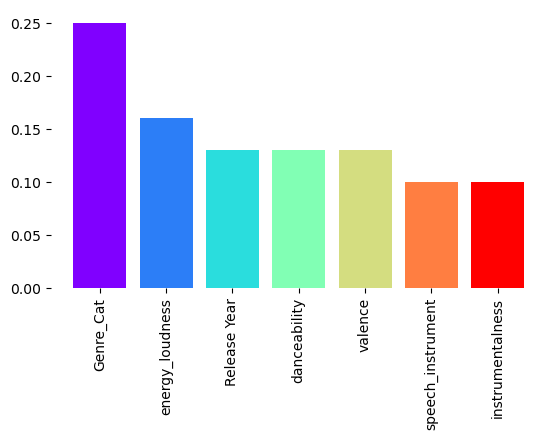

In [68]:
feature_importance(best_grid, features)

### Support Vector Machine

In [69]:
param_grid_svm = {
    'C': [0.5, 100, 150],
    'kernel': ['rbf'],
    'gamma': [0.1, 0.01, 0.001],
    'probability': [True]
}

In [70]:
svm = SVC(kernel='rbf', C = 10)

In [71]:
# Instantiate the grid search model
svm_grid = GridSearchCV(estimator = svm, param_grid = param_grid_svm, 
                        cv = 3, n_jobs = -1, verbose = 2, scoring = 'precision')

In [72]:
# Fitting the SVM
svm_grid.fit(over_X, over_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(C=10), n_jobs=-1,
             param_grid={'C': [0.5, 100, 150], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf'], 'probability': [True]},
             scoring='precision', verbose=2)

In [73]:
print_best_model(svm_grid)

The best parameters are: {'C': 150, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
The best model Precision score is: 0.6798275851360499
The best estimator is: SVC(C=150, gamma=0.001, probability=True)


In [74]:
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_base_svm = svm.predict(X_test)
base_accuracy_svm = accuracy_score(y_test, y_pred_base_svm)

best_grid_svm = svm_grid.best_estimator_

# Make predictions on the test set
y_pred_grid_svm = best_grid_svm.predict(X_test)
grid_accuracy_svm = accuracy_score(y_test, y_pred_grid_svm)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy_svm - base_accuracy_svm) / base_accuracy_svm))

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
classification_rep3 = classification_report(y_test, y_pred_grid_svm)
print('Classification Report:\n', classification_rep3)
print('Base Accuracy: ', base_accuracy_svm)
print('Oversampling Accuracy:', grid_accuracy_svm)

Improvement of 24.57%.
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72       176
           1       0.67      0.57      0.61       148

    accuracy                           0.67       324
   macro avg       0.67      0.66      0.66       324
weighted avg       0.67      0.67      0.67       324

Base Accuracy:  0.5401234567901234
Oversampling Accuracy: 0.6728395061728395


In [75]:
# Calculate confusion matrix
c_m3 = confusion_matrix(y_test, y_pred_grid_svm)

# Calculate precision and recall
precision3 = precision_score(y_test, y_pred_grid_svm)
recall3 = recall_score(y_test, y_pred_grid_svm)
auprc3 = average_precision_score(y_test, y_pred_grid_svm)

# Print results
print("Confusion Matrix:")
print(c_m3)
print("Precision:", precision3)
print("Recall:", recall3)
print("AUPRC:", auprc3)

Confusion Matrix:
[[134  42]
 [ 64  84]]
Precision: 0.6666666666666666
Recall: 0.5675675675675675
AUPRC: 0.5759092425759091


### Logistic Regression

In [76]:
param_grid_log = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'max_iter': [200, 300],
    'penalty': ['l2'],
    'tol':[0.00001, 0.0001],
}

In [77]:
log = LogisticRegression(solver='lbfgs')

In [78]:
# Instantiate the grid search model
log_grid = GridSearchCV(estimator = log, param_grid=param_grid_log, 
                        cv = 10, n_jobs = -1, verbose = 2, scoring='precision')


In [79]:
# Fitting the Logistic Regression
log_grid.fit(over_X, over_y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50, 100, 200],
                         'max_iter': [200, 300], 'penalty': ['l2'],
                         'tol': [1e-05, 0.0001]},
             scoring='precision', verbose=2)

In [80]:
print_best_model(log_grid)

The best parameters are: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'tol': 1e-05}
The best model Precision score is: 0.5918595364695551
The best estimator is: LogisticRegression(C=0.1, max_iter=200, tol=1e-05)


In [81]:
log.fit(X_train, y_train)

# Make predictions on the test set
y_pred_base_log = log.predict(X_test)
base_accuracy_log = accuracy_score(y_test, y_pred_base_log)

best_grid_log = log_grid.best_estimator_

# Make predictions on the test set
y_pred_grid_log = best_grid_log.predict(X_test)
grid_accuracy_log = accuracy_score(y_test, y_pred_grid_log)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy_log - base_accuracy_log) / base_accuracy_log))

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
classification_rep4 = classification_report(y_test, y_pred_grid_log)
print('Classification Report:\n', classification_rep4)
print('Base Accuracy: ', base_accuracy_log)
print('Oversampling Accuracy:', grid_accuracy_log)

Improvement of -2.48%.
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       176
           1       0.57      0.57      0.57       148

    accuracy                           0.61       324
   macro avg       0.61      0.61      0.61       324
weighted avg       0.61      0.61      0.61       324

Base Accuracy:  0.6234567901234568
Oversampling Accuracy: 0.6080246913580247


In [82]:
# Calculate confusion matrix
c_m4 = confusion_matrix(y_test, y_pred_grid_log)

# Calculate precision and recall
precision4 = precision_score(y_test, y_pred_grid_log)
recall4 = recall_score(y_test, y_pred_grid_log)
auprc4 = average_precision_score(y_test, y_pred_grid_log)

# Print results
print("Confusion Matrix:")
print(c_m4)
print("Precision:", precision4)
print("Recall:", recall4)
print("AUPRC:", auprc4)

Confusion Matrix:
[[112  64]
 [ 63  85]]
Precision: 0.5704697986577181
Recall: 0.5743243243243243
AUPRC: 0.5220791261059716


### KNN

In [83]:
# List Hyperparameters that we want to tune.
leaf_size = [1,50]
n_neighbors = [1,30]
p=[1,2]
#Convert to dictionary
param_grid_knn = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [84]:
# Create KNN Object.
knn = KNeighborsClassifier()

In [85]:
# Instantiate the grid search model
knn_grid = GridSearchCV(estimator = knn, param_grid = param_grid_knn, 
                   cv=10, scoring = 'precision')

In [86]:
# Fitting the KNN
knn_grid.fit(over_X, over_y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 50], 'n_neighbors': [1, 30],
                         'p': [1, 2]},
             scoring='precision')

In [87]:
print_best_model(knn_grid)

The best parameters are: {'leaf_size': 50, 'n_neighbors': 30, 'p': 1}
The best model Precision score is: 0.6866178024293201
The best estimator is: KNeighborsClassifier(leaf_size=50, n_neighbors=30, p=1)


In [88]:
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred_base_knn = knn.predict(X_test)
base_accuracy_knn = accuracy_score(y_test, y_pred_base_knn)

best_grid_knn = knn_grid.best_estimator_

# Make predictions on the test set
y_pred_grid_knn = best_grid_knn.predict(X_test)
grid_accuracy_knn = accuracy_score(y_test, y_pred_grid_knn)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy_knn - base_accuracy_knn) / base_accuracy_knn))

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
classification_rep5 = classification_report(y_test, y_pred_grid_knn)
print('Classification Report:\n', classification_rep5)
print('Base Accuracy: ', base_accuracy_knn)
print('Oversampling Accuracy:', grid_accuracy_knn)

Improvement of -5.22%.
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       176
           1       0.65      0.60      0.63       148

    accuracy                           0.67       324
   macro avg       0.67      0.67      0.67       324
weighted avg       0.67      0.67      0.67       324

Base Accuracy:  0.7098765432098766
Oversampling Accuracy: 0.6728395061728395


In [89]:
# Calculate confusion matrix
c_m5 = confusion_matrix(y_test, y_pred_grid_knn)

# Calculate precision and recall
precision5 = precision_score(y_test, y_pred_grid_knn)
recall5 = recall_score(y_test, y_pred_grid_knn)
auprc5 = average_precision_score(y_test, y_pred_grid_knn)

# Print results
print("Confusion Matrix:")
print(c_m5)
print("Precision:", precision5)
print("Recall:", recall5)
print("AUPRC:", auprc5)

Confusion Matrix:
[[129  47]
 [ 59  89]]
Precision: 0.6544117647058824
Recall: 0.6013513513513513
AUPRC: 0.5756301644782037


### Gradient Boosting

In [90]:
# List Hyperparameters that we want to tune.
param_grid_gbm = {
    'n_estimators':[350],
    'learning_rate': [0.1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 50],
    'max_depth': [20, 40, 80],
    'max_features': [2, 3]
}

In [91]:
# Create GBM Object.
gbm = GradientBoostingClassifier()

In [92]:
# Instantiate the grid search model
gbm_grid = GridSearchCV(estimator = gbm, param_grid = param_grid_gbm, scoring='precision', n_jobs=4, cv=5)

In [93]:
# Fitting the GBM
gbm_grid.fit(over_X, over_y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1], 'max_depth': [20, 40, 80],
                         'max_features': [2, 3], 'min_samples_leaf': [2, 5, 50],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [350]},
             scoring='precision')

In [94]:
print_best_model(gbm_grid)

The best parameters are: {'learning_rate': 0.1, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 350}
The best model Precision score is: 0.7478485285293661
The best estimator is: GradientBoostingClassifier(max_depth=20, max_features=3, min_samples_leaf=2,
                           min_samples_split=10, n_estimators=350)


In [95]:
gbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_base_gbm = gbm.predict(X_test)
base_accuracy_gbm = accuracy_score(y_test, y_pred_base_gbm)

best_grid_gbm = gbm_grid.best_estimator_

# Make predictions on the test set
y_pred_grid_gbm = best_grid_gbm.predict(X_test)
grid_accuracy_gbm = accuracy_score(y_test, y_pred_grid_gbm)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy_gbm - base_accuracy_gbm) / base_accuracy_gbm))

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
classification_rep6 = classification_report(y_test, y_pred_grid_gbm)
print('Classification Report:\n', classification_rep6)
print('Base Accuracy: ', base_accuracy_gbm)
print('Oversampling Accuracy:', grid_accuracy_gbm)

Improvement of -3.59%.
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       176
           1       0.74      0.69      0.71       148

    accuracy                           0.75       324
   macro avg       0.75      0.74      0.74       324
weighted avg       0.75      0.75      0.75       324

Base Accuracy:  0.7746913580246914
Oversampling Accuracy: 0.7469135802469136


In [96]:
# Calculate confusion matrix
c_m6 = confusion_matrix(y_test, y_pred_grid_gbm)

# Calculate precision and recall
precision6 = precision_score(y_test, y_pred_grid_gbm)
recall6 = recall_score(y_test, y_pred_grid_gbm)
auprc6 = average_precision_score(y_test, y_pred_grid_gbm)

# Print results
print("Confusion Matrix:")
print(c_m6)
print("Precision:", precision6)
print("Recall:", recall6)
print("AUPRC:", auprc6)

Confusion Matrix:
[[140  36]
 [ 46 102]]
Precision: 0.7391304347826086
Recall: 0.6891891891891891
AUPRC: 0.6513760136948543


Variable: Genre_Cat Importance: 0.28
Variable: energy_loudness Importance: 0.15
Variable: Release Year Importance: 0.13
Variable: danceability Importance: 0.13
Variable: valence Importance: 0.12
Variable: speech_instrument Importance: 0.11
Variable: instrumentalness Importance: 0.09


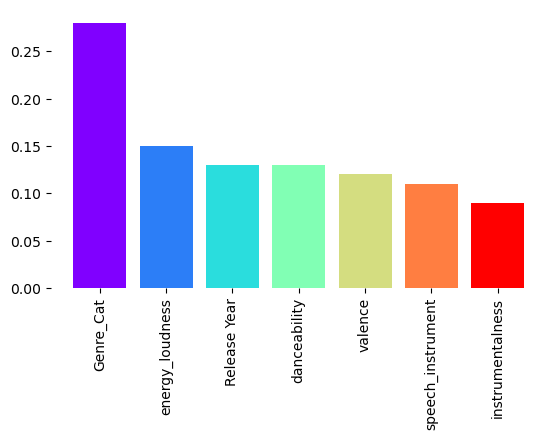

In [97]:
feature_importance(best_grid_gbm, features)

In [98]:
# Define model names
model_names = ['Random Forest', 'OS Random Forest Tuned', 'OS SVM Tuned', 'OS Logistic Regression Tuned', 'OS KNN Tuned', 'OS Gradient Boosting Tuned']

# Define the pre-calculated metrics
#confusion_matrices = [c_m, c_m2, c_m3, c_m4, c_m5, c_m6]
precisions = [precision, precision2, precision3, precision4, precision5, precision6]
recalls = [recall, recall2, recall3, recall4, recall5, recall6]
accuracies = [random_accuracy, grid_accuracy, grid_accuracy_svm, grid_accuracy_log, grid_accuracy_knn, grid_accuracy_gbm]
auprcs = [auprc, auprc2, auprc3, auprc4, auprc5, auprc6]

# Create DataFrame to store results
results_df = pd.DataFrame({
    'Model': model_names,
    #'Confusion Matrix': confusion_matrices,
    'Precision': precisions,
    'Recall': recalls,
    'Accuracy': accuracies,
    'AUPRC': auprcs
})

# Print results
print(results_df)

                          Model  Precision    Recall  Accuracy     AUPRC
0                 Random Forest   0.738095  0.628378  0.728395  0.633556
1        OS Random Forest Tuned   0.725926  0.662162  0.731481  0.635002
2                  OS SVM Tuned   0.666667  0.567568  0.672840  0.575909
3  OS Logistic Regression Tuned   0.570470  0.574324  0.608025  0.522079
4                  OS KNN Tuned   0.654412  0.601351  0.672840  0.575630
5    OS Gradient Boosting Tuned   0.739130  0.689189  0.746914  0.651376


The model with the highest Precision at the training level was the tuned Gradient Boosting at 74.8%. We can observe from our table above that it also did very well at the testing level compared to the other models.

Considering that our aim is to minimize false positives, the best metrics to compare all models by is the Precision and Average Precision (AUPRC). However, we should also take into account the overall balance among the key metrics, including Recall and Accuracy as we would want to minimize false negatives and avoid missing out on potential investment opportunities.

Comparing our models side by side in tabular form, we can see that the best performing model in terms of Precision and AUPRC is the tuned Gradient Boosting model with a Precision of 73.9% and AUPRC of 65.1%. Additionally, we can also observe that the tuned Gradient Boosting model has a high Recall at 68.9% and Accuracy at 74.7%. This performance is closely followed by the tuned Random Forest and the regular Random Forest models. 

Given the outcomes, the minimal performance difference and the significant advantages in computational efficiency, scalability, and simplicity, give the tuned Random Forest the edge. This is a more practical choice for production in many instances. It offers a good balance of performance and efficiency, making it suitable for various industries and applications. Thus, while the tuned Gradient Boosting slightly outperforms the tuned Random Forest in metrics, the tuned Random Forest model's computational efficiency and practicality make it the preferable choice for production deployment. 

Moreover, it was found that "Genre_Cat", "energy_loudness, "Release Year", and "danceability" are among the most important features predictive of "Popularity Category".

The results obtained from the models, while acceptable, are not the best and we may need to consider other approaches to gain a better performance. This may include acquiring more data, incorporating other predictor variables, or even feature engineering additional variables.

## A/B TESTING

## Explicitness Effect on Average Popularity

Below, we will conduct a simple A/B test to find out if there is a statistically significant difference in popularity between tracks with explicit content and those without.

In [99]:
# Define two groups of songs (e.g., explicit vs. non-explicit)
group_explicit = merged_df[merged_df['Explicit'] == True]
group_non_explicit = merged_df[merged_df['Explicit'] == False]

# Perform a t-test to compare the popularity of the two groups
t_stat, p_value = ttest_ind(group_explicit['Popularity Score'], group_non_explicit['Popularity Score'])
if p_value < 0.05:
    print("There is a statistically significant difference in popularity between the two groups.")
else:
    print("There is no statistically significant difference in popularity between the two groups.")

There is a statistically significant difference in popularity between the two groups.


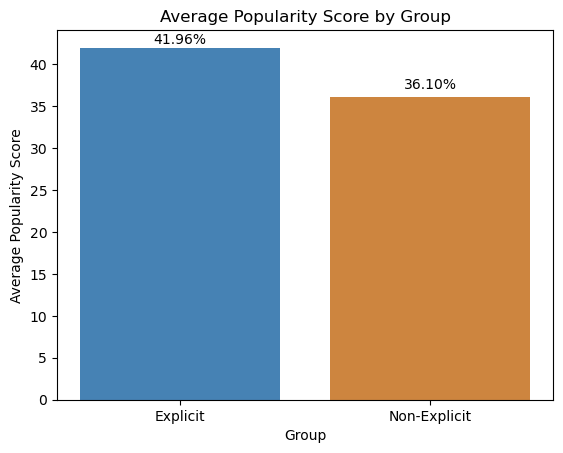

In [100]:
# Calculate the average popularity score for each group
avg_popularity_explicit = group_explicit['Popularity Score'].mean()
avg_popularity_non_explicit = group_non_explicit['Popularity Score'].mean()

# Create a bar chart
plt.bar(['Explicit', 'Non-Explicit'], [avg_popularity_explicit, avg_popularity_non_explicit], color=['steelblue', 'peru'])
plt.xlabel('Group')
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score by Group')

# Add labels with percentage values
plt.text(0, avg_popularity_explicit + 1, f'{avg_popularity_explicit:.2f}%', ha='center', va='center')
plt.text(1, avg_popularity_non_explicit + 1, f'{avg_popularity_non_explicit:.2f}%', ha='center')

plt.show()

In [101]:
# Calculate correlation
correlation = merged_df['Popularity Score'].corr(merged_df['Explicit'])
print(f'Correlation between popularity and explicitness: {correlation}')

Correlation between popularity and explicitness: 0.10366758547959401


Although there is a very small correlation between popularity and explicitness, there is a statistically significant difference in popularity between the explicit and non-explicit track groups. The explicit group seems to have an average popularity score of 41.96%, while the non-explicit an average popularity score of 36.1%.

## KPI'S AND METRICS

## Average Popularity Score by Year

Below, we will explore a popularity metric and observe its trend over the years.

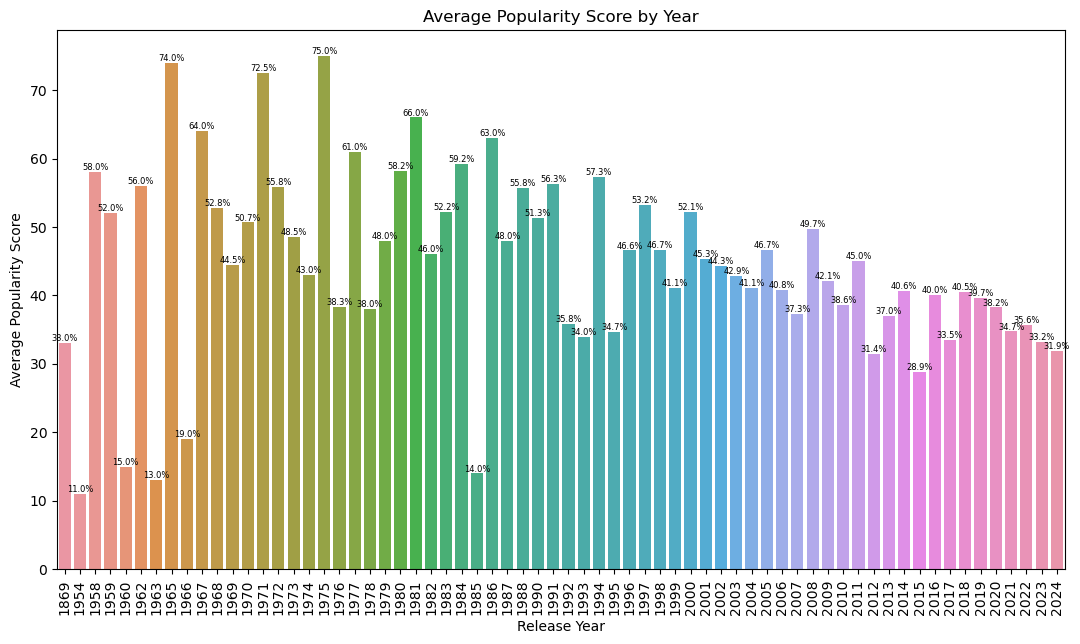

In [102]:
# Calculate average popularity score by year
pop_year = merged_df.groupby(['Release Year'])['Popularity Score'].mean().reset_index()

# Create plot
plt.figure(figsize=(13,7))
ax = sns.barplot(x='Release Year', y='Popularity Score', data=pop_year)
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize = 6)
plt.xticks(rotation=90)
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score by Year')
plt.show()

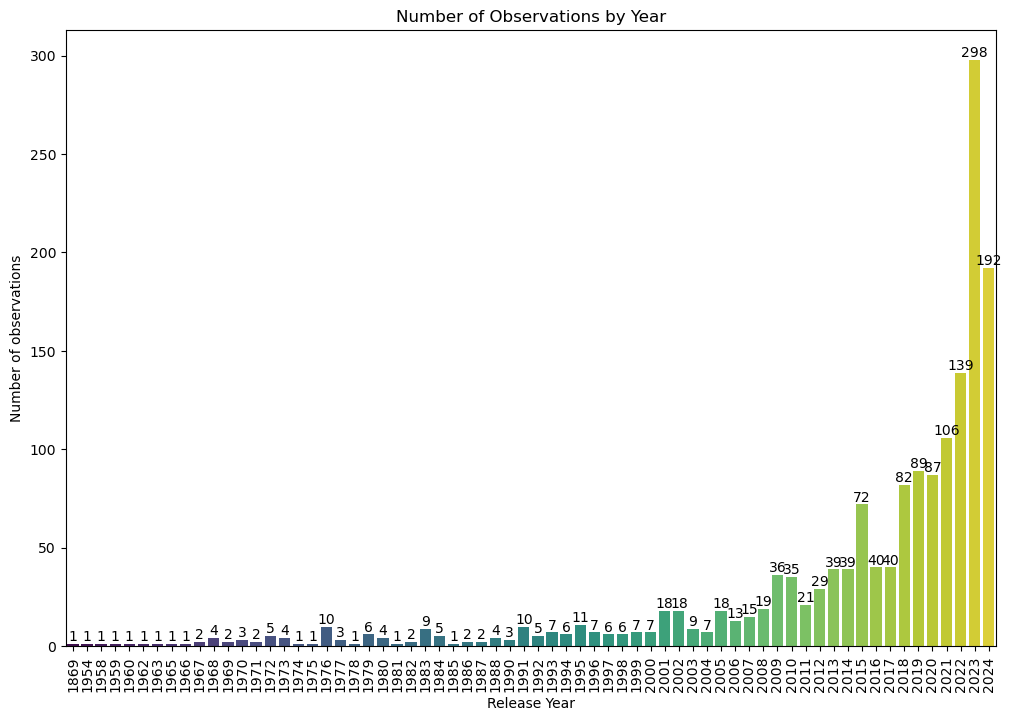

In [103]:
# Count the number of data points per year
data_points_per_year = merged_df['Release Year'].value_counts().reset_index()
data_points_per_year.columns = ['Release Year', 'Data Points']

# Sort the DataFrame by 'Release Year' to maintain yearly order
data_points_per_year = data_points_per_year.sort_values(by='Release Year')

# Create plot
plt.figure(figsize=(12,8))
ax = sns.barplot(x='Release Year', y='Data Points', data=data_points_per_year, palette='viridis')
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize = 10)
plt.xticks(rotation=90)
plt.xlabel('Release Year')
plt.ylabel('Number of observations')
plt.title('Number of Observations by Year')
plt.show()

We can observe in the graphs above that the average popularity score for tracks from 1869 to about 1986 had varying ups and downs, with averages as low as 11% and as high as 75%. On the other hand, from 1987 and onward, the average popularity score has been more or less steady, with averages ranging from the upper 20s% to the upper 50s%. It is also important to note that most of the data points in our data set come from the years 2010 and on, which may explain the balanced averages after a certain period of time.

## Average Track Duration (minutes) by Genre

Below, we will explore a track duration metric and explore how it compares among the different genres.

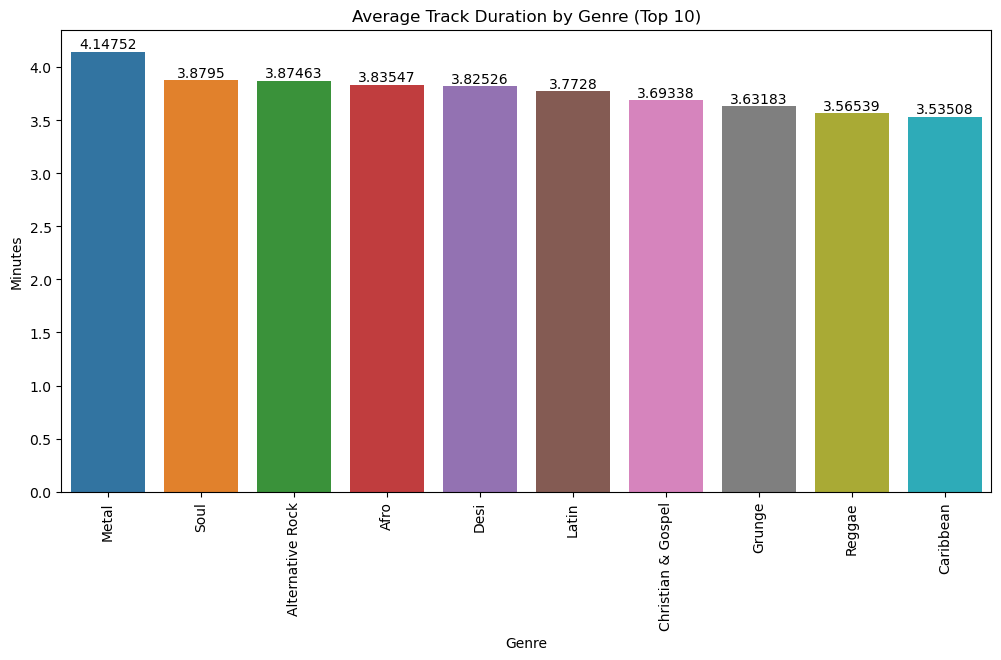

In [104]:
# Calculate average track duration by genre
duration_genre = merged_df.groupby('Genre')['duration_ms'].mean().reset_index()

# Convert duration from milliseconds to minutes
duration_genre['duration_minutes'] = duration_genre['duration_ms'] / 60000

# Sorting by average duration in descending order
duration_genre = duration_genre.sort_values('duration_minutes', ascending=False)

# Filtering the top 10
duration_genre2 = duration_genre.head(10)

# Create plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Genre', y='duration_minutes', data=duration_genre2)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.ylabel('Minutes')
plt.title('Average Track Duration by Genre (Top 10)')
plt.show()

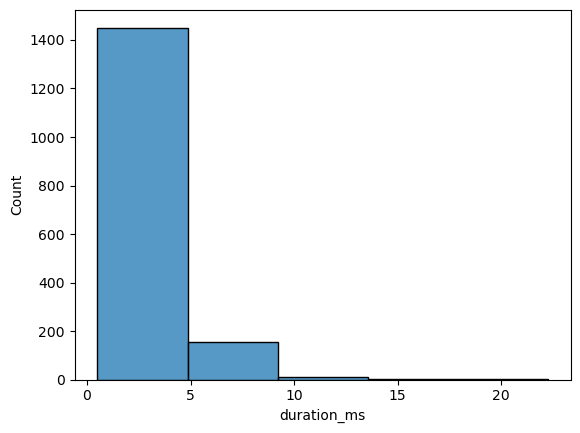

In [105]:
# Convert duration from milliseconds to minutes
duration_mn = merged_df['duration_ms'] / 60000

sns.histplot(duration_mn, bins=5)
plt.show()

As evident in the graph above, the genre with the longest average track duration is "Metal" at 4.1 minutes, followed by Soul and Alternative Rock, with average track durations at 3.9 and 3.9 minutes respectively. 

We can also observe that the distribution of the duration of tracks is right skewed, and most of the observations in our data fall within the 0-5 minute duration.

## Relationship Between Energy and Loudness

We will also explore the relationship between the predictor variables energy and loudness.

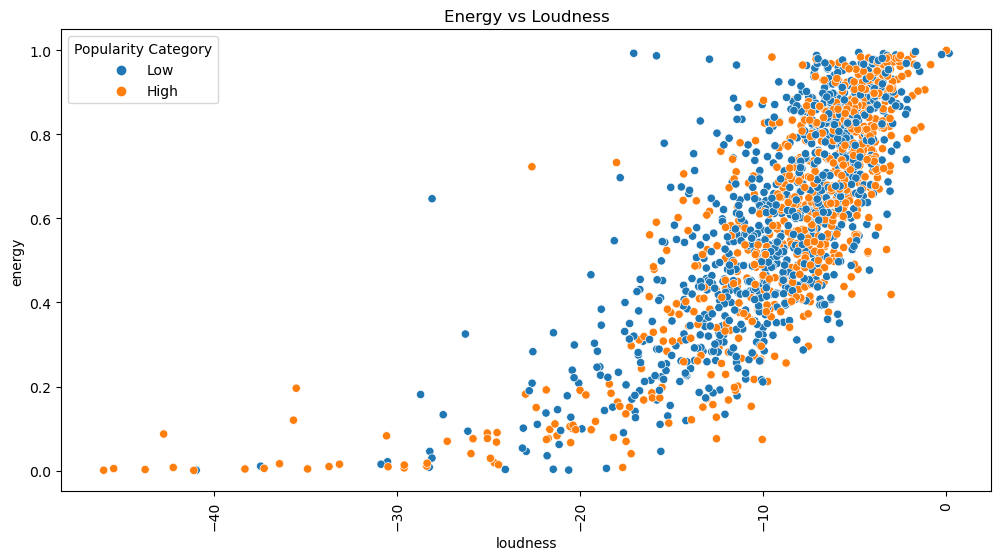

In [106]:
# Create plot
plt.figure(figsize=(12,6))
sns.scatterplot(x='loudness', y='energy', hue='Popularity Category', data=merged_df)
plt.xticks(rotation=90)
plt.title('Energy vs Loudness')
plt.show()

In [107]:
# Calculate correlation
correlation_loud = merged_df['energy'].corr(merged_df['loudness'])
print(f'Correlation between energy and loudness: {correlation_loud}')

Correlation between energy and loudness: 0.7610494694220289


As we were able to previously see on the correlation plot under the Data Visualization section, energy is highly positively correlated with loudness. We have calcualted a correlation coefficient of 0.76 for these two variables. It is also evident in the plot above that as loudness increases, energy also increases, demonstrated by the very clear pattern.

## Relationship Between Energy and Acousticness

Below, we explore the relationship between the predictor variables energy and acousticness.

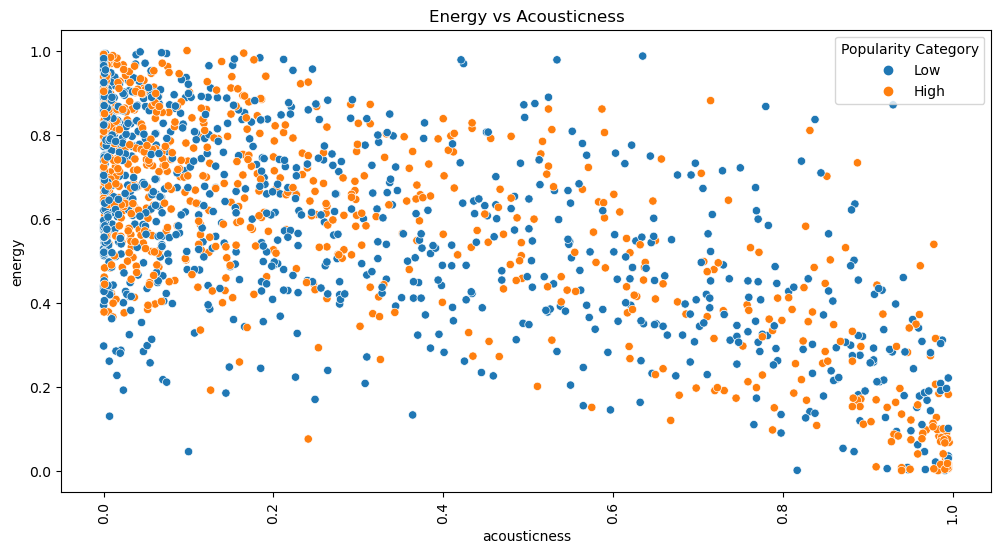

In [108]:
# Create plot
plt.figure(figsize=(12,6))
sns.scatterplot(x='acousticness', y='energy', hue='Popularity Category', data=merged_df)
plt.xticks(rotation=90)
plt.title('Energy vs Acousticness')
plt.show()

In [109]:
# Calculate correlation
correlation_acou = merged_df['energy'].corr(merged_df['acousticness'])
print(f'Correlation between energy and acousticness: {correlation_acou}')

Correlation between energy and acousticness: -0.6826596465577004


As evident in the plot above, we can also observe a clear pattern between energy and acousticness. These two variables are highly negatively correlated with a correlation coefficinet of -0.68. This means that as acousticness increases, energy decreases and vice versa.

## CONCLUSION

Our comprehensive analysis of Spotify music track data aimed to provide actionable insights to drive strategic decision-making for record labels and management. Here are the key findings and recommendations:

### Key Findings

**Popularity Scores:** The average popularity score in our dataset is low at 37.4, with 75% of tracks scoring below 55. The highest score recorded is 94.

**Genres:** "Love" tracks are the most popular, with an average popularity score of 75.5%, followed by "Rock" and "Sleep" genres at 66% and 64.3%, respectively.

**Predictive Features:** Key predictors of track popularity include "Genre," "Energy," "Loudness," "Release Year," and "Danceability."

**Explicit Content:** Explicit tracks have a slightly higher average popularity score (41.96%) compared to non-explicit tracks (36.1%).

**Historical Trends:** From 1987 onwards, the average popularity scores have remained relatively steady, ranging from the upper 20s% to upper 50s%.

**Duration Patterns:** The genre with the longest average track duration is "Metal" (4.1 minutes), followed by "Soul" and "Alternative Rock" (3.9 minutes each).

**Model Selection:** While the tuned Gradient Boosting model slightly outperforms the tuned Random Forest in metrics, the Random Forest is chosen for production due to its computational efficiency, scalability, and simplicity. It provides a practical balance of performance and resource usage, making it suitable for industry applications.

**Feature Correlations:**  High energy is associated with high loudness (correlation of 0.76), and high acousticness is associated with low energy (correlation of -0.68).


### Recommendations

**Focus on Popular Genres:** Invest in promoting tracks from the "Love," "Rock," and "Sleep" genres, as these show higher popularity.

**Utilize Key Features:** Use key features such as genre, energy, loudness, release year, and danceability to guide marketing and promotional strategies to enhance track visibility.

**Deploy Efficient Models:** Deploy the tuned Random Forest model for predicting track popularity due to its balance of performance and computational efficiency, enabling strategic decision-making and targeted investent.

**Explore Additional Data:** Consider acquiring additional data or incorporating other predictor variables to enhance the predictive performance of the models and gain deeper insights into factors influencing track popularity.

These insights provide a strategic framework to help record labels and management optimize their investments, track visibility, and promotional efforts, thereby driving greater audience engagement and maximizing the impact of music releases.